In [113]:
#Note if you are using google colab - please go to Runtime -> Change runtime type  and select GPU as Hardware accelerator. This will make notebook run faster.
#github link: https://github.com/sanigam/BERT_Medium

#Install following libraries before first run. For subsequent runs, you may comment these
# !pip install tensorflow==2.1.0
# !pip install tensorflow_hub
# !pip install bert-for-tf2
# !pip install sentencepiece

#Importing Required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from bert import bert_tokenization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from  sklearn.utils import shuffle
#Tensorflow version
print("Tensorflow Version:", tf.__version__)



Tensorflow Version: 2.1.0


In [105]:
df = pd.read_csv('True.csv')
df['target'] =1
print(df.shape)
df1 = pd.read_csv('Fake.csv')
df1['target'] =0
print(df1.shape)
df = df.append (df1)
df = shuffle(df)
print(df.shape)

(21417, 5)
(23481, 5)
(44898, 5)


In [106]:
df['text1'] = df['title'] + ' . ' + df['text']
df.head()

,title,text,subject,date,target,text1
19331,Civilians leave IS-area in eastern Syria after...,BEIRUT (Reuters) - Hundreds of civilians left ...,worldnews,"September 22, 2017",1,Civilians leave IS-area in eastern Syria after...
2157,Trump's Strategic and Policy Forum to disband:...,(Reuters) - Members of U.S. President Donald T...,politicsNews,"August 16, 2017",1,Trump's Strategic and Policy Forum to disband:...
2720,Virginia Seeks To Hold Trump In Contempt For ...,Donald Trump could end up behind bars if the s...,News,"February 2, 2017",0,Virginia Seeks To Hold Trump In Contempt For ...
17607,New Zealand kingmaker party to hold key board ...,WELLINGTON (Reuters) - The leader of the small...,worldnews,"October 12, 2017",1,New Zealand kingmaker party to hold key board ...
7990,Washington Post calls for Maine governor to re...,BOSTON (Reuters) - The Washington Post on Wedn...,politicsNews,"September 28, 2016",1,Washington Post calls for Maine governor to re...


In [107]:
# #Loading newss Data, you can load from file in your computer or from github link. 
# #For a different use case, you can load different file in similar format

# #df = pd.read_csv('newss.csv') #From your computer
# df = pd.read_csv('https://raw.githubusercontent.com/sanigam/BERT_Medium/master/newss.csv') #From github link


# print ( f'Data Shape: {df.shape} ') #Number of rows and column in data-frame


,title,text,subject,date,target,text1
15731,Ex-Argentina VP Boudou arrested in corruption ...,"BUENOS AIRES (Reuters) - Amado Boudou, who had...",worldnews,"November 3, 2017",1,Ex-Argentina VP Boudou arrested in corruption ...
17043,Col. Ralph Peters On Obama’s Refusal To Live I...,Peters is dead on in his description of Obama ...,Government News,"Oct 13, 2015",0,Col. Ralph Peters On Obama’s Refusal To Live I...



Sample Fake News(target = 0):
-------------------------------
FORMER DEMOCRAT WARNS Young Americans: “Rioters are being manipulated by big government forces who need them to regain political power” [VIDEO] .  Who is silencing political speech, physically attacking those with divergent views, demanding that every American share one single  ideology. But sadly, the real truth is that these violent agitators have little idea about why they march. Theirs is a movement with no cause, a temper tantrum with no purpose. They are a generation lost in space .a propaganda arm of the party of disappointment. If I were wrong, would Hillary Clinton really be their standard bearer? These rioters are being manipulated by big government forces who need them to regain political power 

Sample True News (target = 1):
--------------------------------------
Afghan Shi'ites fear further attacks on Ashura celebrations . KABUL (Reuters) - The Afghan capital Kabul braced on Saturday for further possible attac

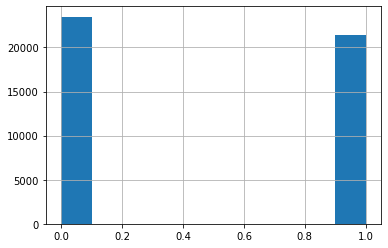

In [108]:
#Optional Step: Looking into data
display(df.sample(2)) #Sample rows of dataframe

print ( '\nSample Fake News(target = 0):\n-------------------------------')
print ( df[df['target']==0].text1.values[100] )

print ( '\nSample True News (target = 1):\n--------------------------------------')
print ( df[df['target']==1].text1.values[100] )

print ( '\nTrue (1)  and Fake News (0)\n------------------------------------------------------------------------')
df['target'].hist() ;

In [109]:
# Splitting data into test and training
df_train, df_test = train_test_split( df , test_size=0.20, random_state=42)

print( f'Training Data Shape: {df_train.shape}  ,  Test Data Shape:  {df_test.shape}') # Rows/Cols in train/test data

Training Data Shape: (35918, 6)  ,  Test Data Shape:  (8980, 6)


In [110]:
#Loading BERT Standard model (Pretrained Model on Wikipedia and Book Corpus)
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True, name = 'keras_bert_layer' )

#Getting vocab file from bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy() 

do_lower_case = True  # For uncased model it will True 

#Defining tokenizer object which will be used to tokenize text before feeding to bert
tokenizer_for_bert = bert_tokenization.FullTokenizer(vocab_file, do_lower_case) #Tokenizer to tokenize input text

print ( '\nLength of vocab in our tokenizer : ' , len(tokenizer_for_bert.vocab) ) #BERT vocab has around 30K words


Length of vocab in our tokenizer :  30522


In [111]:
#Function to encode text in format to feed to BERT

def encode_text_for_bert (texts, tokenizer_for_bert, max_len=512):
    ''' This function is to encode data for inputting into BERT model
    Parameters:
    texts - List of texts to encode
    tokenizer_for_bert - Tokenizer to be used to convert text into tokens
    max_len - Maximum length of text. It can have maximum value as 512
    Return: Tupple of 3 numpy arrays 
    1) Token Ids padded with 0s to make length as max_len.  
    2) Array where we have 1 for actual tokens and 0 for padding tokens
    3) Array of 0s to indicate that token belongs to 1st sentence (chunk of text). There is no 2nd sentence here.
    '''
    all_token_ids = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        tokens = tokenizer_for_bert.tokenize(text) #Tokenizing using Bert tokenizer
            
        tokens = tokens[:max_len-2] # Truncating number of tokens to max_len -2, Reduced extra 2 to add special tokens
        
        input_sequence = ["[CLS]"] + tokens + ["[SEP]"]  # [CLS] and [SEP] are special tokens to be added into input text
        
        pad_len = max_len - len(input_sequence) # Spaces to fill with 0s to make each sequence equal to max_len
        
        token_ids = tokenizer_for_bert.convert_tokens_to_ids(input_sequence)   #Converting tokens to token ids 
       
        token_ids += [0] * pad_len  #Padding token ids with 0s
        
        pad_masks = [1] * len(input_sequence) + [0] * pad_len # 1 where we have sentence tokens and 0 otherwise
        
        segment_ids = [0] * max_len # Segment ids are all 0 to indicate it is part of sentence 1. There is no sentence 2 here
        
        all_token_ids.append(token_ids)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_token_ids), np.array(all_masks), np.array(all_segments)


In [112]:
#Optional Step: This is just to understand input/output of function encode_text_for_bert
test_text =  "Welcome to  BERT session "

print ("Test text after tokenization: " ,  ["[CLS]"] + tokenizer_for_bert.tokenize( test_text)  + ["[SEP]"] )

print ("Test text after encoding: " ,encode_text_for_bert ( [test_text], tokenizer_for_bert, 7 ) ) # Pl Note id 101 is for token [CLS] and 102 for token [SEP]

Test text after tokenization:  ['[CLS]', 'welcome', 'to', 'bert', 'session', '[SEP]']
Test text after encoding:  (array([[  101,  6160,  2000, 14324,  5219,   102,     0]]), array([[1, 1, 1, 1, 1, 1, 0]]), array([[0, 0, 0, 0, 0, 0, 0]]))


In [36]:
#Creating BERT  Model 
def bert_model_creation (bert_layer, max_len=512, model_type = 'Classification', num_classes = 2):
    '''This function is to create BERT model for Classification or Regession Task
    Parameters:
    model_type = 'Classification' for classification task or 'Regression' for regression task. 
    num_classes = Number of classes in classification task. Value of 2 means binary classification. More than 2 for multiclass classification.
                  For regression, num_classes parameter is ignored.
    Return: Deep Learning Model
    Important: You may add additional dense layers in place holder provided as "***PLACEHOLDFER FOR ADDITIONAL LAYERS****"
    '''   
    #Input to bert layer
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    #Output from bert layer
    bert_layer_out = bert_layer([input_word_ids, input_mask, segment_ids]) # Python list of 2 tensors with shape (batch_size, 768) and (batch_size, max_len, 768)
    
    #Extrating Embedding for CLS token comming out of bert layer. Note CLS is the first token
    cls_out = bert_layer_out[1][:,0,:] # Getting hidden-state of 1st tokens from second tensor in bert_layer_out, Tensor shape - (batch size, 768) 
    
    
    #***PLACEHOLDFER FOR ADDITIONAL LAYERS****. 
    #Add more layers here if you want. See example below
    #cls_out = Dropout(.25) (cls_out)
    #cls_out = Dense(500, activation='relu')(cls_out) 
    
    
    
    #Defines last layer depending on model type and  number of classes. Activation function is used depending on model_type and num_classes
    if model_type == 'Classification' :
        if num_classes == 2 :
            out = Dense(1, activation='sigmoid')(cls_out)     # ** For Binary classification, use sigmoid activation
        else:    
            out = Dense(num_classes, activation='softmax')(cls_output) # For Multi Class classification, use softmax activation
    else:
        out = Dense(1, activation='linear')(cls_out)     # For regression, use linear activation
    
    #Model creation using inputs and output
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out, name='deeplearning_bert__model')
    
    
    
    learning_rate = 2e-6 # modify learning rate,as needed
    
    #Compiles Model depending on model type and number of classes. Loss function as well as metrics is used accordingly
    if model_type == 'Classification' :
        if num_classes == 2 :
            model.compile(Adam(lr= learning_rate), loss='binary_crossentropy', metrics=['acc']) # ** For Binary classification
        else:
            model.compile(Adam(lr= learning_rate), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy']) # For Multi Class classification 
    else:
        model.compile(Adam(lr= learning_rate), loss='mse', metrics=['mse']) # For Regression
        
    return model

In [37]:
max_len = 250 #Max length of text input to model. It can go up to 512. Keeping it small to run it faster

In [47]:
#Building Classification Model
#modify values of model_type and num_classes as per need
model = bert_model_creation(bert_layer, max_len=max_len, model_type = 'Classification', num_classes = 2) #binary classification as num_classes = 2

#Model Summary. Pl note, there are ~109 Million parameters as it is BERT standard model
model.summary() 

Model: "deeplearning_bert__model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 250)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 250)]        0                                            
__________________________________________________________________________________________________
keras_bert_layer (KerasLayer)   [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask

In [57]:
#Encoding Training Data for BERT.  If you want  preprocessing/cleaning of input text, it should be done before this step
train_input = encode_text_for_bert(df_train['text1'].values, tokenizer_for_bert, max_len= max_len)

#Output variable as 0s or 1s for binary classification. It can have more distinct values for multi-class classification or continous values for regression
y_train = df_train['target'].values 

In [58]:
#Optional step: Checking accuracy on train news before fine-tuning so that we can see improvement by fine tuning
#accuracy_score( y_train, np.round(model.predict(train_input)).flatten() )

In [59]:
#Model Training (Fine-tuning for news classification)
epochs = 1       #Modify as neded
batch_size = 32  #Modify as needed
train_history = model.fit(train_input, y_train ,epochs= epochs,batch_size= batch_size, verbose=1)

Train on 35918 samples
35918/35918 [==============================] - 571s 16ms/sample - loss: 8.9137e-04 - acc: 0.9998


In [60]:
#Checking accuracy on train news
#accuracy_score( y_train, np.round(model.predict(train_input)) )

In [61]:
#Encoding test data into BERT Format. If you have  preprocessing/cleaning of input text, it should be done before this step

test_input = encode_text_for_bert(df_test['text1'].values, tokenizer_for_bert, max_len= max_len)
y_test = df_test['target'].values

#Checking accuracy on test news. You may be able to improve it by taking bigger length of text, more epochs or by adding more dense layers into the model
accuracy_score( y_test, np.round(model.predict(test_input)) )

0.9985523385300669

In [73]:
#Running model on single text. Validating model for True text

news = 'U.S. Army General Gus Perna, chief operating officer of Operation Warp Speed, said Saturday he expects the first COVID-19 vaccine shipments will arrive at 145 sites in states across the country on Monday. '



prediction = model.predict (  encode_text_for_bert ( [news], tokenizer_for_bert, max_len=max_len) ) 
print('News Text: ', news)
print ( 'News Type: ', np.where(  prediction >= .5 , "True", "Fake" ) , '   Score:',  prediction)

News Text:  U.S. Army General Gus Perna, chief operating officer of Operation Warp Speed, said Saturday he expects the first COVID-19 vaccine shipments will arrive at 145 sites in states across the country on Monday. 
News Type:  [['Fake']]    Score: [[0.08849972]]


In [74]:
#Running model on single text. Validating model for fake text

news = "Bill Gates’ personal doctor told a medical symposium in Seattle that the Microsoft founder refused to vaccinate his children."

prediction = model.predict (  encode_text_for_bert ( [news], tokenizer_for_bert, max_len=max_len) ) 
print('News Text: ', news)
print ( 'News Type: ', np.where(  prediction >= .5 , "True", "Fake" ) , '   Score:',  prediction)

News Text:  Bill Gates’ personal doctor told a medical symposium in Seattle that the Microsoft founder refused to vaccinate his children.
News Type:  [['Fake']]    Score: [[0.0019539]]


In [64]:
model.save('Fake_news.h5')

In [114]:
model = load_model ('Fake_news.h5')

ValueError: Unknown layer: KerasLayer

In [82]:
#Running model on single text. Validating model for True text

news = 'Ebola Epidemic Becomes Global Health Crisis. The deadliest outbreak of Ebola, a deadly hemorrhagic fever, started in West Africa in the spring of 2014 and began to spread rapidly in late summer. Most of the epidemic was contained in three countries -- Guinea, Sierra Leone and Liberia -- though there have been cases in confirmed in at least five other countries, including two diagnosed in the United States. '



prediction = model.predict (  encode_text_for_bert ( [news], tokenizer_for_bert, max_len=max_len) ) 
print('News Text: ', news)
print ( 'News Type: ', np.where(  prediction >= .5 , "True", "Fake" ) , '   Score:',  prediction)

News Text:  Ebola Epidemic Becomes Global Health Crisis. The deadliest outbreak of Ebola, a deadly hemorrhagic fever, started in West Africa in the spring of 2014 and began to spread rapidly in late summer. Most of the epidemic was contained in three countries -- Guinea, Sierra Leone and Liberia -- though there have been cases in confirmed in at least five other countries, including two diagnosed in the United States. 
News Type:  [['Fake']]    Score: [[0.2038865]]


In [100]:
i=600
print(df_test['text1'].values[i])
model.predict (  encode_text_for_bert ( [df_test['text1'].values[i]], tokenizer_for_bert, max_len=max_len) ) 

Did OPRAH Just Leave “Nasty” Hillary Wishing She Wouldn’t Have Endorsed Her? [VIDEO] . Four months ago, Oprah, the woman who made her fortune off preying on women s emotions and counting on their inability to think for themselves, gave Hillary s vagina an endorsement. She gave women absolutely no credible reason to support her, but reminded them, when you walk into the voting booth the choice is clear, one candidate has a vagina and the other one does not: Regardless of your politics, it s a seminal moment for women. What this says is, there is no ceiling, that ceiling just went boom! It says anything is possible when you can be leader of the free world. What Oprah s essentially saying to women who hang on her every word is that it doesn t matter if you or your husband don t have a job. It doesn t matter if you live in a town supported by coal that Hillary promised to destroy. It doesn t matter that Hillary left our nation s top secret classified emails exposed for anyone in the world 

array([[0.00016482]], dtype=float32)

In [101]:
df_test.iloc[i]

title      Did OPRAH Just Leave “Nasty” Hillary Wishing S...
text       Four months ago, Oprah, the woman who made her...
subject                                             politics
date                                            Oct 22, 2016
target                                                     0
text1      Did OPRAH Just Leave “Nasty” Hillary Wishing S...
Name: 12664, dtype: object

In [102]:
#Running model on single text. Validating model for True text

news = 'Trump is president of USA'


prediction = model.predict (  encode_text_for_bert ( [news], tokenizer_for_bert, max_len=max_len) ) 
print('News Text: ', news)
print ( 'News Type: ', np.where(  prediction >= .5 , "True", "Fake" ) , '   Score:',  prediction)

News Text:  Trump is president of USA
News Type:  [['Fake']]    Score: [[0.01417429]]
